Importación de librerías 
------------

In [1]:
import os
import sys
import ntpath

import numpy as np

import tensorflow as tf
from tensorflow import keras

# Change this with the directory where you cloned the imgdetect-utils repo
basedir = os.path.join(os.path.expanduser('~'), 'TT', 'my_tensorflow', 'imgdetect-utils' )
sys.path.append(os.path.join(basedir))

print (basedir)

from src.image_helpers import plot_images_grid, create_dataset_files
from src.train_helpers import load_data, plot_results, export_model

# The Tensorflow model and properties file will be stored here
tf_model_dir = os.path.join(basedir, 'models', 'ir', 'tensorflow')
tf_model_file = os.path.join(tf_model_dir, 'ir.pb')
tf_properties_file = os.path.join(tf_model_dir, 'ir.json')

# Base directory that contains your training images and dataset files
dataset_base_dir = os.path.join(basedir, 'datasets', 'ir')
dataset_dir = os.path.join(dataset_base_dir, 'data')

# Store your thermal camera images here
img_dir = os.path.join(dataset_base_dir, 'images')

# Size of the input images
input_size = (24, 32)
input_size

/home/abraham/TT/my_tensorflow/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/abraham/TT/my_tensorflow/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/abraham/TT/my_tensorflow/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/abraham/TT/my_tensorflow/venv/lib/pyt

/home/abraham/TT/my_tensorflow/imgdetect-utils


(24, 32)

Creación de directorios de modelos
------------------------

In [2]:
os.makedirs(tf_model_dir, mode=0o775, exist_ok=True)

Creación de un dataset por las imagenes disponibles
------------------------------------------------

In [3]:
dataset_files = create_dataset_files(img_dir, dataset_dir,
                                     split_size=1000,
                                     num_threads=1,
                                     resize=input_size)
dataset_files

Processing 485 images to 1 dataset files. Format: /home/abraham/TT/my_tensorflow/imgdetect-utils/datasets/ir/data/dataset{:01}.npz
Storing dataset vectors to /home/abraham/TT/my_tensorflow/imgdetect-utils/datasets/ir/data/dataset0.npz


['/home/abraham/TT/my_tensorflow/imgdetect-utils/datasets/ir/data/dataset0.npz']

Cargar el dataset
------------------------------

In [4]:
dataset_files = [os.path.join(dataset_dir, f)
                 for f in os.listdir(dataset_dir)
                 if os.path.isfile(os.path.join(dataset_dir, f))
                 and f.endswith('.npz')]

dataset_files

['/home/abraham/TT/my_tensorflow/imgdetect-utils/datasets/ir/data/dataset0.npz']

Dividir el set de datos con distribución 70/30
-------------------------------------------------------------------------------

In [5]:
train_set, test_set, classes = load_data(*dataset_files, split_percentage=0.7)
print('Loaded {} training images and {} test images. Classes: {}'.format(
    train_set.shape[0], test_set.shape[0], classes))

Loaded 339 training images and 146 test images. Classes: ['negative' 'positive']


In [6]:
train_images = np.asarray([item[0] for item in train_set])
train_labels = np.asarray([item[1] for item in train_set])
test_images = np.asarray([item[0] for item in test_set])
test_labels = np.asarray([item[1] for item in test_set])

Inspeccionar las 25 primeras imágenes
-----------------------------------------------


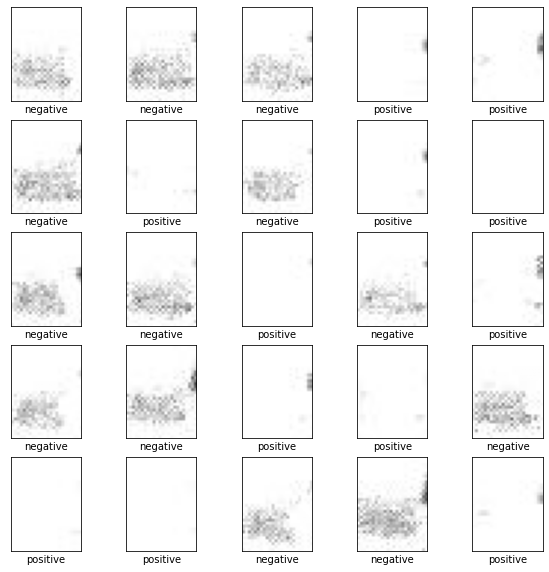

In [7]:
plot_images_grid(images=train_images, labels=train_labels, classes=classes, rows=5, cols=5)


Declaración del modelo
-----------------

* Flatten input
* Layer 1: 60% the number of pixels per image
* Layer 2: 30% the number of pixels per image
* Layer 3: as many neurons as the output labels (in this case 2: negative, positive)

In [8]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=train_images[0].shape),
    keras.layers.Dense(int(0.6 * train_images.shape[1] * train_images.shape[2]), activation=tf.nn.relu),
    keras.layers.Dense(int(0.3 * train_images.shape[1] * train_images.shape[2]), activation=tf.nn.relu),
    keras.layers.Dense(len(classes), activation=tf.nn.softmax)
])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Compile the model
-----------------

- *Loss function*:This measures how accurate the model is during training. We want to minimize this function to "steer" the model in the right direction.
- *Optimizer*: This is how the model is updated based on the data it sees and its loss function.
- *Metrics*: Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.

In [9]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Entrenamiento
---------------

In [10]:
model.fit(train_images, train_labels, epochs=100)

Epoch 1/100
339/339 [==============================] - 0s 474us/sample - loss: 1.9868 - acc: 0.5192
Epoch 2/100
339/339 [==============================] - 0s 143us/sample - loss: 0.7952 - acc: 0.5103
Epoch 3/100
339/339 [==============================] - 0s 128us/sample - loss: 0.7177 - acc: 0.5664
Epoch 4/100
339/339 [==============================] - 0s 132us/sample - loss: 0.7380 - acc: 0.5723
Epoch 5/100
339/339 [==============================] - 0s 135us/sample - loss: 0.7048 - acc: 0.5133
Epoch 6/100
339/339 [==============================] - 0s 122us/sample - loss: 0.6697 - acc: 0.5457
Epoch 7/100
339/339 [==============================] - 0s 122us/sample - loss: 0.6554 - acc: 0.5251
Epoch 8/100
339/339 [==============================] - 0s 122us/sample - loss: 0.6672 - acc: 0.5693
Epoch 9/100
339/339 [==============================] - 0s 144us/sample - loss: 0.6356 - acc: 0.5516
Epoch 10/100
339/339 [==============================] - 0s 119us/sample - loss: 0.5329 - acc: 0.8201

Evaluación de precisión en comparación con el dataset
--------------------------------------

In [11]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

146/146 [==============================] - 0s 145us/sample - loss: 0.1396 - acc: 0.9726
Test accuracy: 0.9726027


Predicciones
--------------------------------

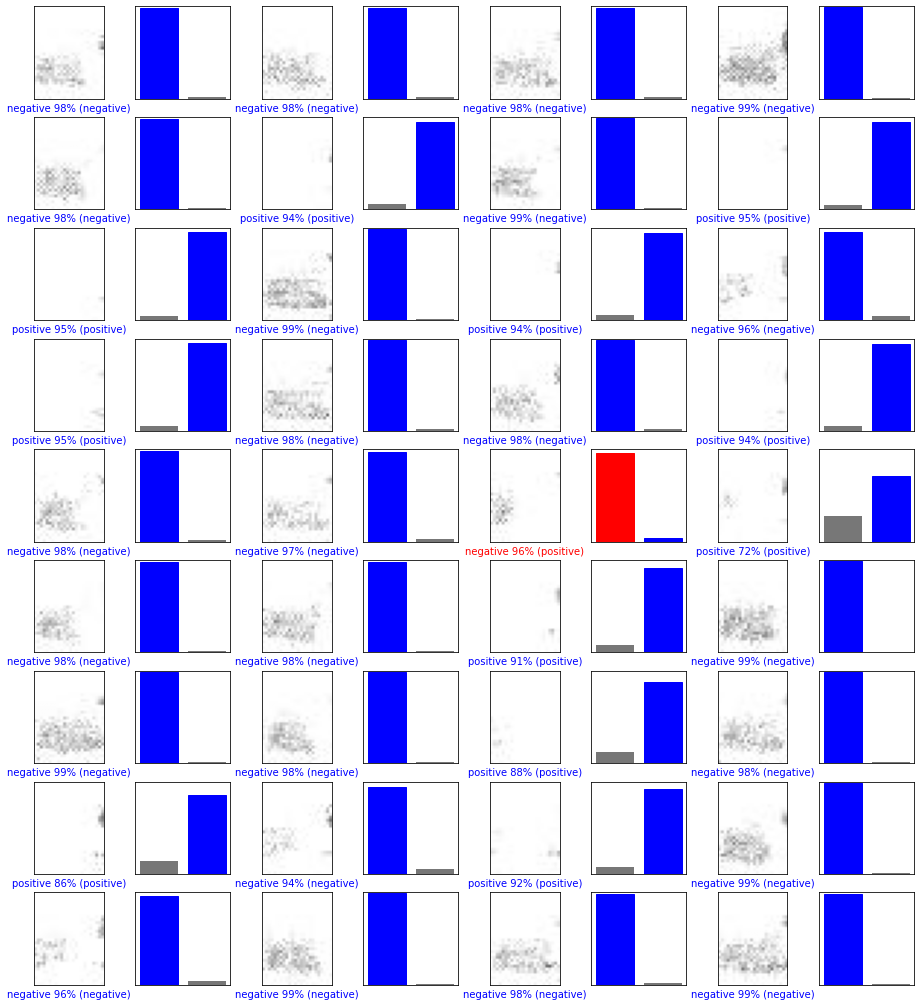

In [12]:
predictions = model.predict(test_images)
plot_results(images=test_images, labels=test_labels, classes=classes, predictions=predictions, rows=9, cols=4)

Exportar modelo Tensorflow
----------------------------

In [13]:
export_model(model, tf_model_file,
             properties_file=tf_properties_file,
             classes=classes,
             input_size=input_size)



Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 23 variables.
INFO:tensorflow:Converted 23 variables to const ops.

